In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf



In [2]:
# anulo el uso de la GPU por falta de memoria
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0' #'-1' for no GPU

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# No GPU found

# tf.enable_eager_execution()
tf.VERSION

GPU found


'1.13.1'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2

from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import keras.backend as K

from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train


DATA_PATH = "data"

Using TensorFlow backend.


In [4]:
import os
print(os.listdir("data"))

['results_df_20190710232755.pkl', 'results_test_df_20190710232755.pkl', 'processed_train_images', 'results_df_20190711090031.pkl', 'results_test_models_df_20190711111832.pkl', 'results_test_df_20190712001832.pkl', 'train.csv', 'results_df.pkl', 'train_images', 'test.csv', 'test_images', 'results_test_df_20190711090031.pkl', 'processed_test_images', 'results_test_df.pkl', 'sample_submission.csv', 'results_df_20190712001832.pkl', 'results_test_model2_df_20190711111855.pkl', 'results_test_model2_df_20190712083607.pkl']


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 634369610578500687
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12967669852955048430
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13564942867497283740
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7201334887
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1547176074573735505
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# 1. Introduction. Explore first, train later.

Hi everyone! As *Aravind Eye Hospital* is one of my favorite organization in the world; they take care of poor people's eyes for free with an impressive sustainable business model.  I will try my best to contribute something to our community. One intuitive way to improve the performance of our model is to simply improve the quality of input images. In this kernel, I will share two ideas which I hope may be useful to some of you : 

- **Decolorize images** : here as we will see, images come with many different lighting conditions, some images are quite dark and difficult to visualize. We can try to convert the image to gray scale, and visualize better. Alternatively, we can try the method of [Ben Graham (last competition's winner)](https://github.com/btgraham/SparseConvNet/tree/kaggle_Diabetic_Retinopathy_competition)
- **Cropping uninformative area** : everyone know this :) Here, I just find the codes from internet and choose the best one for you :)

We are going to apply both techniques to both the official data, and the past competition data (shout out @tanlikesmath for creating this dataset! https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized . In the updated version, I also try @donkeys' dataset https://www.kaggle.com/donkeys/retinopathy-train-2015 , which is .png which may be have higer image quality than .jpeg format)

If I found more useful tricks, I will update the notebook, or if you have more useful tricks and would love to share, please let me know!

I use some parts of codes from @mathormad and @artgor kernels. Thanks both of you!

Now let us start by loading the train/test dataframes. The `train_test_split` here is in fact not necessary. But when I first fork the kernel from @mathormad, I found some interesting examples using this split and the current `SEED`, so I continue to use them here.

In [6]:
df_train = pd.read_csv(DATA_PATH + '/train.csv')
df_test = pd.read_csv(DATA_PATH + '/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)


(3662,) (3662,)


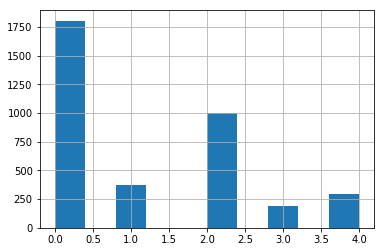

In [7]:
print(x.shape,  y.shape)
y.hist()

In [8]:
print(df_train.groupby('diagnosis').count())

           id_code
diagnosis         
0             1805
1              370
2              999
3              193
4              295


In [9]:
d_x1 = {}
d_y1 = {}
index = 0
num_images_ = [450, 370, 400, 193, 295]
for j in range(0,5):
    for i,(a,b) in enumerate(df_train.loc[df_train['diagnosis'] == j].\
                       sample(num_images_[j], random_state=SEED).iterrows()):
        d_x1[index]= b[0]
        d_y1[index]= b[1]
        index += 1

x1 = pd.Series(d_x1)
y1 = pd.Series(d_y1)

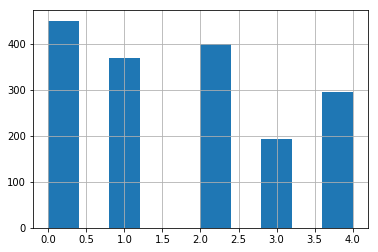

In [10]:
y1.hist()

In [11]:
num_images = len(x1)
print(num_images)

1708


## 1.1 Simple picture to explain Diabetic Retinopathy

How do we know that a patient have diabetic retinopahy? There are 5 things to spot on. Image credit https://www.eyeops.com/
![credit : https://www.eyeops.com/](https://sa1s3optim.patientpop.com/assets/images/provider/photos/1947516.jpeg)

From quick investigations of the data (see various pictures below), I found that *Hemorrphages, Hard Exudates and Cotton Wool spots* are quite easily observed. However, I still could not find examples of *Aneurysm* or *Abnormal Growth of Blood Vessels* from our data yet. Perhaps the latter two cases are important if we want to catch up human benchmnark using our model.

## Process Images

In [12]:
def crop_image1(img,tol=8):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]


In [13]:
def enhance(image, clip_limit=3, Crop = True, size=(400,500)):
    # convert image to LAB color model
    
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # split the image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(image_lab)

    # apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L channel with the original A and B channel
    merged_channels = cv2.merge((cl, a_channel, b_channel))

    # convert iamge from LAB color model back to RGB color model
    image = cv2.cvtColor(merged_channels, cv2.COLOR_LAB2BGR)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Auto Crop image
    cropped_image = crop_image1(image_gray, 8)
    
    # resize image
    resized_image = cv2.resize(cropped_image, size)
    # Include Ben Graham preprocessing (-4 value)
    if Crop:
        final_image=cv2.addWeighted ( resized_image,4, 
                                     cv2.GaussianBlur( resized_image , (0,0) , IMG_SIZE/10) ,-4 ,128)
        return final_image
    else:
        return resized_image

In [14]:
import tqdm

# Aquí transcribimos las imágenes a un fichero tipo TFRECORD de tamaño
# el primer modelo usaba imágenes de 100x125
width = 400
height = 500

size = (width,height)


if os.path.isfile("/mnt/DATA-SSD/DataSandbox/APTOS/image_array.npy") == False:
    image_x = []

    for i in tqdm.tqdm(x1):
        path=f"/mnt/DATA-SSD/DataSandbox/APTOS/train_images/{i}.png"
        image = cv2.imread(path)
        enhanced_image = enhance(image,2, True, size)
        # img = image.img_to_array(enhanced_image)
        img = enhanced_image.reshape((width, height, 1))/255
        image_x.append(img)

    X = np.array(image_x)
    X.tofile("/mnt/DATA-SSD/DataSandbox/APTOS/image_array.npy")
else:
    X = np.fromfile("/mnt/DATA-SSD/DataSandbox/APTOS/image_array.npy", dtype=float)
    X.reshape((num_images, width, height, 1))


if os.path.isfile("/mnt/DATA-SSD/DataSandbox/APTOS/category_array.npy") == False:
    Y = to_categorical(y1)
    Y.tofile("/mnt/DATA-SSD/DataSandbox/APTOS/category_array.npy")
else:
    Y = np.fromfile("/mnt/DATA-SSD/DataSandbox/APTOS/category_array.npy", dtype=int)
    Y.reshape((num_images, 5))

100%|██████████| 1708/1708 [05:51<00:00,  4.94it/s]


In [15]:
print(len(x), X.shape)
print(len(Y), Y.shape)

3662 (1708, 400, 500, 1)
1708 (1708, 5)


# The Model
## inspired in real life

help obtained from
https://machinelearningmastery.com/keras-functional-api-deep-learning/


In [16]:
# ---------------------
# OPTION 1
# ---------------------
''' '''

input_layer = tf.keras.Input(shape=(width,height,1))
print('input_layer: ', input_layer.shape)

layer1 = tf.keras.layers.Conv2D(200, kernel_size=(5, 5), activation='relu')(input_layer)
print('layer: ', layer1.shape)

layer2 = tf.keras.layers.MaxPooling2D(pool_size=(5, 5))(layer1)
print('layer: ', layer2.shape)

layer3 = tf.keras.layers.Conv2D(200, kernel_size=(2, 2), activation='relu')(layer2)
print('layer: ', layer3.shape)

layer4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer3)
print('layer: ', layer4.shape)

layer5 = tf.keras.layers.Conv2D(100, kernel_size=(2, 2), activation='relu')(layer4)
print('layer: ', layer5.shape)

layer6 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer5)
print('layer: ', layer6.shape)

layer7 = tf.keras.layers.Flatten()(layer6)
print('layer: ', layer7.shape)

layer8 = tf.keras.layers.Dense(10*NUM_CLASSES, activation='relu')(layer7)
print('layer: ', layer8.shape)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(layer8)
print('output_layer: ', output_layer.shape)

model = tf.keras.Model(inputs = [input_layer], outputs = [output_layer])



input_layer:  (?, 400, 500, 1)
Instructions for updating:
Colocations handled automatically by placer.
layer:  (?, 396, 496, 200)
layer:  (?, 79, 99, 200)
layer:  (?, 78, 98, 200)
layer:  (?, 39, 49, 200)
layer:  (?, 38, 48, 100)
layer:  (?, 19, 24, 100)
layer:  (?, 45600)
layer:  (?, 50)
output_layer:  (?, 5)


In [17]:
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 500, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 396, 496, 200)     5200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 99, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 98, 200)       160200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 49, 200)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 48, 100)       80100     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 24, 100)       0         
__________

In [18]:
# config = tf.ConfigProto(device_count = {'GPU': 0})
# config.gpu_options.allow_growth = True
# gpu_options = tf.GPUOptions(allow_growth=True)

# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))


In [19]:
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [21]:
import datetime
# este es el modelo estándar, con la entrada y la salida esperadas
# hay que sustituirlo por un iterador.


# No olvidarse de incluir un train_history para recuperar los datos del entrenamiento
# 5000 epochs es una locura y el número de steps per epoch es muy bajo (no se recorren todas las imagenes)
# el mínimo steps_per_epoch debería de ser total_muestras/batch_size

lt = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

model_file = "/mnt/DATA-SSD/DataSandbox/APTOS/model_" + lt + "_{epoch:04d}.h5"

# with callback
train_history = model.fit(X, Y,
                          batch_size = 10,
                          epochs=300,
                          verbose=1,
                          callbacks = [tf.keras.callbacks.ModelCheckpoint(model_file, 
                                                                          save_weights_only = False,
                                                                          verbose=1,
                                                                          period=10)])


Instructions for updating:
Use tf.cast instead.
Epoch 1/300
1708/1708 [==============================] - 29s 17ms/sample - loss: 1.4121 - acc: 0.3987
Epoch 2/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 1.2228 - acc: 0.5076
Epoch 3/300
1708/1708 [==============================] - 28s 16ms/sample - loss: 1.1831 - acc: 0.5357
Epoch 4/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 1.1488 - acc: 0.5457
Epoch 5/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 1.1240 - acc: 0.5574
Epoch 6/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 1.0816 - acc: 0.5714
Epoch 7/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 1.0213 - acc: 0.5960
Epoch 8/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.9614 - acc: 0.6311
Epoch 9/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.8802 - acc: 0.6540
Epoch 10/300
1700/1708 [==========

1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0492 - acc: 0.9842
Epoch 69/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0360 - acc: 0.9871
Epoch 70/300
1700/1708 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9818
Epoch 00070: saving model to /mnt/DATA-SSD/DataSandbox/APTOS/model_20190712131547_0070.h5
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0444 - acc: 0.9813
Epoch 71/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0399 - acc: 0.9859
Epoch 72/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0356 - acc: 0.9848
Epoch 73/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0436 - acc: 0.9854
Epoch 74/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0349 - acc: 0.9854
Epoch 75/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0318 - acc: 0.9854
Epoch 76/300
1708

1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0203 - acc: 0.9889
Epoch 136/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0210 - acc: 0.9883
Epoch 137/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0227 - acc: 0.9871
Epoch 138/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0265 - acc: 0.9859
Epoch 139/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0401 - acc: 0.9848
Epoch 140/300
1700/1708 [============================>.] - ETA: 0s - loss: 0.0769 - acc: 0.9753
Epoch 00140: saving model to /mnt/DATA-SSD/DataSandbox/APTOS/model_20190712131547_0140.h5
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0765 - acc: 0.9754
Epoch 141/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0463 - acc: 0.9836
Epoch 142/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0743 - acc: 0.9760
Epoch 143/

1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0175 - acc: 0.9889
Epoch 203/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0184 - acc: 0.9889
Epoch 204/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0182 - acc: 0.9895
Epoch 205/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0169 - acc: 0.9895
Epoch 206/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0180 - acc: 0.9889
Epoch 207/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0181 - acc: 0.9859
Epoch 208/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0174 - acc: 0.9871
Epoch 209/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0753 - acc: 0.9772
Epoch 210/300
1700/1708 [============================>.] - ETA: 0s - loss: 0.0758 - acc: 0.9688
Epoch 00210: saving model to /mnt/DATA-SSD/DataSandbox/APTOS/model_20190712131547_0210

Epoch 271/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0200 - acc: 0.9883
Epoch 272/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0159 - acc: 0.9877
Epoch 273/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0153 - acc: 0.9877
Epoch 274/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0151 - acc: 0.9883
Epoch 275/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0153 - acc: 0.9883
Epoch 276/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.1104 - acc: 0.9672
Epoch 277/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0466 - acc: 0.9842
Epoch 278/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0187 - acc: 0.9889
Epoch 279/300
1708/1708 [==============================] - 27s 16ms/sample - loss: 0.0157 - acc: 0.9906
Epoch 280/300
1700/1708 [============================>.] - ETA: 

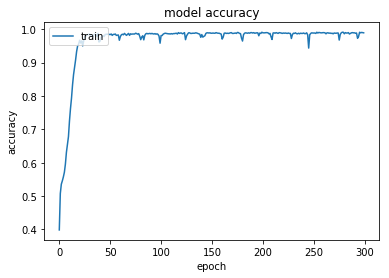

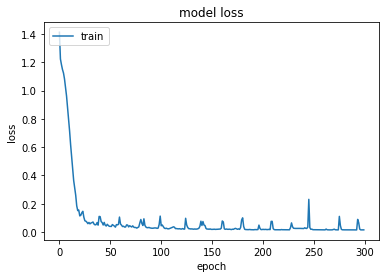

In [22]:
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# Choose 5 random images one for each different diagnosis value

image_list = []
for class_id in sorted(y.unique()):
    image_list.append(df_train.loc[df_train['diagnosis'] == class_id].sample(1, random_state=SEED))

image_list

[           id_code  diagnosis
 1361  5ead17e894ae          0,            id_code  diagnosis
 3305  e580676516b0          1,           id_code  diagnosis
 520  2532613a584a          2,            id_code  diagnosis
 2200  9a94e0316ee3          3,          id_code  diagnosis
 88  07122e268a1d          4]

In [29]:
predict = {}

for i in image_list:
    path=f"/mnt/DATA-SSD/DataSandbox/APTOS/train_images/{i.iloc[0][0]}.png"
    print(path)
    image = cv2.imread(path)
    enhanced_image = enhance(image,2, True, size)
    # img = image.img_to_array(enhanced_image)
    img = enhanced_image.reshape((1,width, height, 1))/255
    predict[i.iloc[0][0]] = [i.iloc[0][1], model.predict(img)]


predict

/mnt/DATA-SSD/DataSandbox/APTOS/train_images/5ead17e894ae.png
/mnt/DATA-SSD/DataSandbox/APTOS/train_images/e580676516b0.png
/mnt/DATA-SSD/DataSandbox/APTOS/train_images/2532613a584a.png
/mnt/DATA-SSD/DataSandbox/APTOS/train_images/9a94e0316ee3.png
/mnt/DATA-SSD/DataSandbox/APTOS/train_images/07122e268a1d.png


{'5ead17e894ae': [0,
  array([[1.0000000e+00, 4.5184591e-15, 9.6389352e-10, 7.2417619e-18,
          2.5658836e-22]], dtype=float32)],
 'e580676516b0': [1,
  array([[1.3640036e-05, 9.9996662e-01, 7.0218414e-07, 9.1704379e-08,
          1.8900526e-05]], dtype=float32)],
 '2532613a584a': [2,
  array([[1.5784126e-11, 5.5813703e-13, 9.9996996e-01, 2.0285550e-07,
          2.9854053e-05]], dtype=float32)],
 '9a94e0316ee3': [3,
  array([[2.6363989e-22, 7.8877273e-14, 7.3314212e-13, 1.0000000e+00,
          1.2774484e-09]], dtype=float32)],
 '07122e268a1d': [4,
  array([[4.8076716e-12, 5.3118013e-12, 2.1298158e-10, 1.9084519e-10,
          1.0000000e+00]], dtype=float32)]}

In [30]:
results_train = {}
for i in tqdm.tqdm(df_train.iterrows()):
    path=f"/mnt/DATA-SSD/DataSandbox/APTOS/train_images/{i[1][0]}.png"
    image = cv2.imread(path)
    enhanced_image = enhance(image,2, True, size)
    # img = image.img_to_array(enhanced_image)
    img = enhanced_image.reshape((1,width, height, 1))/255
    results_train[i[0]] = [i[1][0], i[1][1], model.predict(img)]


3662it [11:56,  4.79it/s]


In [31]:
results_df = pd.DataFrame.from_dict(results_train, 
                                    orient='index', 
                                    columns=['imge_id', 'diagnoses', 'prediction'])

In [32]:
def diagnoses_from_list(row):
    n = 0.0
    diagnoses = 0.0
    for i in row[0]:
        diagnoses += i*n
        n += 1.0
    return int(diagnoses)



In [33]:
# print(results_df.iloc[0][2])
# print(diagnoses_from_list(results_df.prediction[0]))
results_df['predicted_diagnoses'] = results_df.apply( lambda x: diagnoses_from_list(x.prediction), axis=1)
results_df['predict_ok'] = results_df.apply( lambda x: 1 if x.predicted_diagnoses==x.diagnoses else 0, axis=1)
results_df['predict_error'] = results_df.apply( lambda x: 1 if x.predicted_diagnoses!=x.diagnoses else 0, axis=1)
results_df['prediction_error'] = results_df['diagnoses'].sub(results_df['predicted_diagnoses'])
results_df.sum(axis=0)
# results_df

imge_id                000c1434d8d7001639a390f00024cdab0c1e002c21358c...
diagnoses                                                           4127
prediction             [[1667.6982, 520.7544, 739.0252, 296.88675, 43...
predicted_diagnoses                                                 3932
predict_ok                                                          2774
predict_error                                                        888
prediction_error                                                     195
dtype: object

In [34]:
results_df.groupby('diagnoses').count()


,imge_id,prediction,predicted_diagnoses,predict_ok,predict_error,prediction_error
diagnoses,,,,,,
0,1805,1805,1805,1805,1805,1805
1,370,370,370,370,370,370
2,999,999,999,999,999,999
3,193,193,193,193,193,193
4,295,295,295,295,295,295


In [35]:
results_df.groupby('diagnoses').sum()

,predicted_diagnoses,predict_ok,predict_error,prediction_error
diagnoses,,,,
0,301,1635,170,-301
1,354,352,18,16
2,1767,544,455,231
3,524,138,55,55
4,986,105,190,194


In [38]:
lt = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
results_df.to_pickle(f"/mnt/DATA-SSD/DataSandbox/APTOS/results_df_{lt}.pkl")